In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.auto import tqdm

In [2]:
import tensorflow_addons as tfa

In [3]:
# do we have a gpu 
gpu = torch.cuda.is_available()

if gpu:
    device = torch.cuda.current_device()
    print(f'GPU device: {device}')
else: 
    print('No GPU')


No GPU


## Data Prep

In [4]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")
validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

In [5]:
keep_keys = ['ane', 'ate', 'autor', 'zeff', 'gammae', 
              'q', 'smag', 'alpha', 'ani1', 'ati0', 'ti_te0', 'x', 'normni1', 'machtor', 'lognustar', 'efiitg_gb']

In [6]:
train_data = train_data[keep_keys]
validation_data = validation_data[keep_keys]

nt, nv = train_data.shape[0], validation_data.shape[0]
nt_nan, nv_nan =  train_data['efiitg_gb'].isna().sum(), validation_data['efiitg_gb'].isna().sum()

train_data = train_data.dropna()
validation_data = validation_data.dropna()

assert train_data.shape[0] + nt_nan == nt
assert validation_data.shape[0] + nv_nan == nv

train_data['efiitg_gb'].loc[train_data['efiitg_gb'] != 0] = 1

validation_data['efiitg_gb'].loc[validation_data['efiitg_gb'] != 0] = 1

assert len(train_data['efiitg_gb'].unique()) == 2
assert len(validation_data['efiitg_gb'].unique()) == 2

In [7]:
x_train, y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()
x_val, y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [8]:
# standard scaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform (x_val)

### Dealing with Class imbalance

To deal with our class imbalance we will add sample weights to each class using the inverse number of samples

In [9]:
def get_weights(num_of_classes: int, samples_per_class: np.ndarray, power: int =1): 
    weights_for_samples = 1/samples_per_class
    weights_for_samples = weights_for_samples/np.sum(weights_for_samples)*num_of_classes
    return weights_for_samples

In [10]:
n_stable = len(y_train[y_train==0])
n_nstable = len(y_train[y_train==1])

print(f'N stable: {n_stable}, N unstable: {n_nstable}')

w = get_weights(2,np.array([n_stable,n_nstable]))

N stable: 12951558, N unstable: 4719843


In [11]:
w = get_weights(2,np.array([n_stable,n_nstable]))
    
class_weights = {0:w[0], 1:w[1]}

In [12]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

## Classifier (tensorflow implementation)

In [13]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation = 'softmax')   
    ])
    return model

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
model = nn_classifier()

2022-04-28 11:18:28.185784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 11:18:28.969085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14639 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0


In [16]:
train_shuffle = np.random.permutation(y_train.shape[0])
valid_shuffle = np.random.permutation(y_val.shape[0])

x_train, y_train = x_train[train_shuffle], y_train[train_shuffle]
x_val, y_val = x_val[valid_shuffle], y_val[valid_shuffle]

In [17]:
x_train_sample, y_train_sample = x_train, y_train

In [18]:
f1 = tfa.metrics.F1Score(num_classes=2, threshold=0.5, average="weighted" )
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc', f1])
stop_early = tf.keras.callbacks.EarlyStopping(monitor ='val_f1_score', patience = 5, mode='max')
history = model.fit(x_train_sample,
                    y_train_sample,
                    class_weight=class_weights,
                    validation_data = (x_val, y_val),
                    batch_size = 4096,
                    epochs = 100, 
                   callbacks=[stop_early])

Epoch 1/100
4315/4315 [==============================] - 31s 6ms/step - loss: 0.1022 - acc: 0.9425 - f1_score: 0.9434 - val_loss: 0.0956 - val_acc: 0.9590 - val_f1_score: 0.9594
Epoch 2/100
4315/4315 [==============================] - 23s 5ms/step - loss: 0.0827 - acc: 0.9538 - f1_score: 0.9544 - val_loss: 0.0949 - val_acc: 0.9588 - val_f1_score: 0.9593
Epoch 3/100
4315/4315 [==============================] - 23s 5ms/step - loss: 0.0791 - acc: 0.9558 - f1_score: 0.9564 - val_loss: 0.0876 - val_acc: 0.9622 - val_f1_score: 0.9626
Epoch 4/100
4315/4315 [==============================] - 23s 5ms/step - loss: 0.0772 - acc: 0.9569 - f1_score: 0.9574 - val_loss: 0.0877 - val_acc: 0.9620 - val_f1_score: 0.9624
Epoch 5/100
4315/4315 [==============================] - 24s 5ms/step - loss: 0.0759 - acc: 0.9576 - f1_score: 0.9581 - val_loss: 0.0841 - val_acc: 0.9638 - val_f1_score: 0.9641
Epoch 6/100
4315/4315 [==============================] - 23s 5ms/step - loss: 0.0751 - acc: 0.9581 - f1_score:

In [19]:
# model = tf.keras.models.load_model("saved_model/itg_classifier")

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [21]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

In [22]:
test_data = test_data[keep_keys]

nt = test_data.shape[0]
nt_nan =  test_data['efiitg_gb'].isna().sum()

test_data = test_data.dropna()

assert test_data.shape[0] + nt_nan == nt

test_data['efiitg_gb'].loc[test_data['efiitg_gb'] != 0] = 1

assert len(test_data['efiitg_gb'].unique()) == 2

In [23]:
x_test, y_test = test_data.iloc[:,:-1].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [24]:
x_test = scaler.transform(x_test)

In [25]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [26]:
y_test.shape

(2209776, 2)

In [27]:
predictions = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test[:,1], predictions[:,1])
auc = roc_auc_score(y_test, predictions)

Text(0.8, 0.2, 'auc =  1.00')

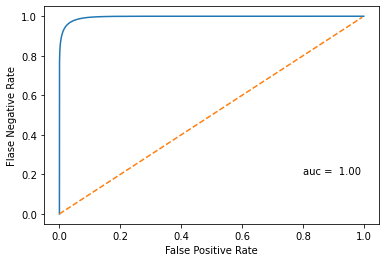

In [28]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

In [29]:
test_pred = np.where(predictions[:,1] < 0.5, predictions[:,1], 1)
test_pred = np.where(predictions[:,1] >= 0.5, test_pred, 0)

n_positive = np.where(y_test[:,1] ==0)[0].shape[0]
n_negative = np.where(y_test[:,1] ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

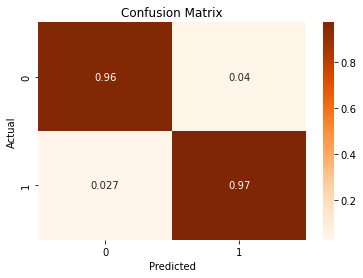

In [30]:
con_mat = confusion_matrix(y_test[:,1], test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True, cmap ='Oranges').set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');
# plt.savefig("ITG_Con_full.png", dpi=300)

In [31]:
x_train.shape

(17671401, 15)

In [32]:
data_dict = pickle.load(open("/home/tmadula/submit/outputs/itg_outputs_3.pkl", 'rb'))

In [33]:
data_dict.keys()

dict_keys(['training_size', 'train_losses', 'val_losses', 'train_f1', 'val_f1', 'eval_out'])

In [34]:
training_size = data_dict['training_size']
val_losses = data_dict['val_losses']
val_f1 = data_dict['val_f1']

In [35]:
model=nn_classifier()
model.build(input_shape =(1,15))

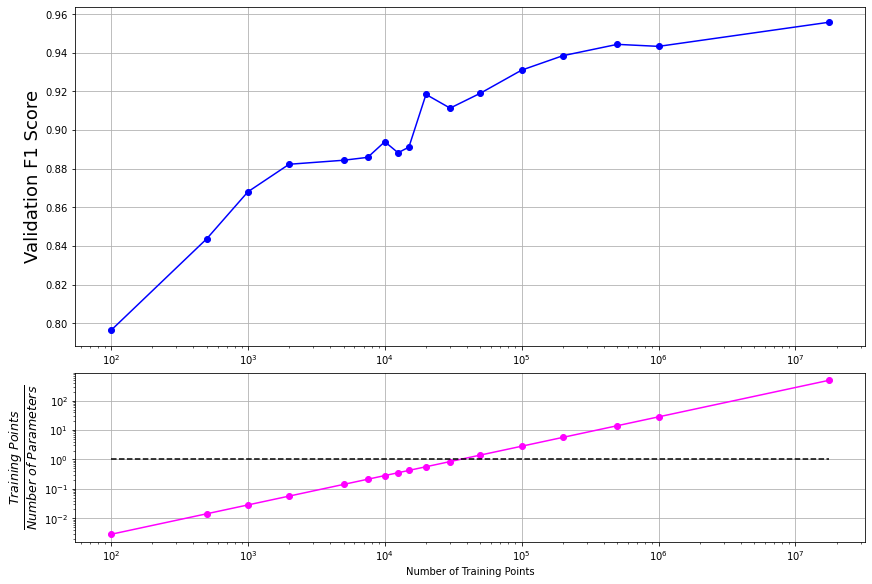

In [36]:
loss_ = [x[-1] for x in val_losses]
f1_ = [x[-1] for x in data_dict['eval_out']]
# acc_ = [x[-2] for x in data_dict['eval_out']]

trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
ratio = training_size / trainable_params


mosaic = """
    A
    A
    B
"""

fig = plt.figure(constrained_layout= True, figsize = (12,8))

ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].plot(training_size, f1_, "-o", color ='blue')
# ax_dict["A"].plot(training_size, acc_, "-o")

ax_dict["A"].set_xscale("log");
ax_dict["A"].set_ylabel("Validation F1 Score", size = 18);
ax_dict["A"].grid()

ax_dict["B"].plot(training_size, ratio, "-o", color = "magenta")
ax_dict["B"].set_xscale("log");
ax_dict["B"].set_yscale("log");
ax_dict["B"].hlines(1, training_size[0], training_size[-1], linestyles = "dashed", color = "k")
ax_dict["B"].grid()
ax_dict["B"].set_ylabel(r"$\frac{Training\ Points}{Number\ of\ Parameters}$", size = 18);

plt.xlabel("Number of Training Points");

# plt.savefig("ITG_F1.png", dpi=300)

In [43]:
# !pip install shap

In [44]:
import shap
from scripts.utils import train_keys

ModuleNotFoundError: No module named 'shap'

In [ ]:
x_train_df = pd.DataFrame(x_train, columns = train_keys)
x_val_df = pd.DataFrame(x_val, columns = train_keys)

In [ ]:
f = lambda x: model.predict(x)
med = np.median(x_train, axis = 0).reshape((1,x_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(x_val_df.iloc[:1000])

In [ ]:
shap.plots.beeswarm(shap_values, max_display = 20)